## Experiment 2: Comparison between k-medoids and Fast k-medoids (section 3.3)

In [1]:
import os, sys, random
import polars as pl
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', 'src')
config_path = os.path.join(current_path, '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_1

from experiments_utils import (make_experiment_2, 
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names)

from config_experiment_2 import get_config as get_config_exp_2

In [2]:
experiment_2_config = get_config_exp_2()

In [3]:
from sklearn_extra.cluster import KMedoids
from FastKmedoids.models import FastKmedoidsGGower

models = {
    'KMedoids-euclidean': KMedoids(n_clusters=experiment_2_config['n_clusters'], 
                                   metric='euclidean', 
                                   method=experiment_2_config['method'], 
                                   init=experiment_2_config['init'], 
                                   max_iter=experiment_2_config['max_iter'], 
                                   random_state=experiment_2_config['random_state']),

    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': FastKmedoidsGGower(
            n_clusters=experiment_2_config['n_clusters'], 
            method=experiment_2_config['method'], 
            init=experiment_2_config['init'], 
            max_iter=experiment_2_config['max_iter'], 
            random_state=experiment_2_config['random_state'],
            frac_sample_size=experiment_2_config['frac_sample_size'], 
            p1=experiment_2_config['p1'], 
            p2=experiment_2_config['p2'], 
            p3=experiment_2_config['p3'], 
            d1='robust_mahalanobis', 
            d2='jaccard', 
            d3='hamming', 
            robust_method='trimmed', 
            alpha=experiment_2_config['alpha'], 
            epsilon=experiment_2_config['epsilon'], 
            n_iters=experiment_2_config['n_iters'],
            VG_sample_size=experiment_2_config['VG_sample_size'], 
            VG_n_samples=experiment_2_config['VG_n_samples']) 

}


In [4]:
n_realizations = 2
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

In [5]:
results = {}

for random_state in random_state_list: 
    print('random_state', random_state)       
    results[random_state] = make_experiment_2(n_samples_list = experiment_2_config['n_samples_list'], 
                                              models = models, 
                                              random_state = random_state)


random_state 107
KMedoids-euclidean
1000
5000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
1000
5000
random_state 548
KMedoids-euclidean
1000
5000
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
1000
5000


In [7]:
results

{107: {'time': {1000: {'KMedoids-euclidean': 0.41529226303100586,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 1.0207505226135254},
   5000: {'KMedoids-euclidean': 6.883626937866211,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 2.2489535808563232}},
  'adj_accuracy': {1000: {'KMedoids-euclidean': 0.729,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.708},
   5000: {'KMedoids-euclidean': 0.7312,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.9098}},
  'ARI': {1000: {'KMedoids-euclidean': 0.6676037990761852,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.5295380158017228},
   5000: {'KMedoids-euclidean': 0.6659081889842104,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.7730818271732389}}},
 548: {'time': {1000: {'KMedoids-euclidean': 0.2661776542663574,
    'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.8068411350250244},
   

In [9]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_2_config['n_samples_list'], 
                                  iterable2 = model_names)

pivoted_results

{'time': {1000: {'KMedoids-euclidean': [0.41529226303100586,
    0.2661776542663574],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': [1.0207505226135254,
    0.8068411350250244]},
  5000: {'KMedoids-euclidean': [6.883626937866211, 7.810791730880737],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': [2.2489535808563232,
    3.013176679611206]}},
 'adj_accuracy': {1000: {'KMedoids-euclidean': [0.729, 0.959],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': [0.708,
    0.684]},
  5000: {'KMedoids-euclidean': [0.7312, 0.7208],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': [0.9098,
    0.8292]}},
 'ARI': {1000: {'KMedoids-euclidean': [0.6676037990761852, 0.8917460443224807],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': [0.5295380158017228,
    0.4579248812221685]},
  5000: {'KMedoids-euclidean': [0.6659081889842104, 0.6533446162786276],
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-ja

In [11]:
avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_2_config['n_samples_list'], 
                                  iterable2 = model_names)

avg_results

{'time': {1000: {'KMedoids-euclidean': 0.34073495864868164,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.9137958288192749},
  5000: {'KMedoids-euclidean': 7.347209334373474,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 2.6310651302337646}},
 'adj_accuracy': {1000: {'KMedoids-euclidean': 0.844,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.696},
  5000: {'KMedoids-euclidean': 0.726,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.8695}},
 'ARI': {1000: {'KMedoids-euclidean': 0.779674921699333,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.4937314485119456},
  5000: {'KMedoids-euclidean': 0.659626402631419,
   'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.694039978122587}}}

In [12]:
avg_results['adj_accuracy']

{1000: {'KMedoids-euclidean': 0.844,
  'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.696},
 5000: {'KMedoids-euclidean': 0.726,
  'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming': 0.8695}}

In [13]:
dfs = avg_results_to_dfs(avg_results, column_1='n_samples', column_2='model_name')

In [14]:
dfs['adj_accuracy']

,n_samples,model_name,adj_accuracy
0,1000,KMedoids-euclidean,0.8440
1,1000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,0.6960
2,5000,KMedoids-euclidean,0.7260
3,5000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,0.8695


In [15]:
dfs['ARI']

,n_samples,model_name,ARI
0,1000,KMedoids-euclidean,0.779675
1,1000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,0.493731
2,5000,KMedoids-euclidean,0.659626
3,5000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,0.694040


In [16]:
dfs['time']

,n_samples,model_name,time
0,1000,KMedoids-euclidean,0.340735
1,1000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,0.913796
2,5000,KMedoids-euclidean,7.347209
3,5000,FastKmedoidsGGower-robust_mahalanobis_trimmed-...,2.631065


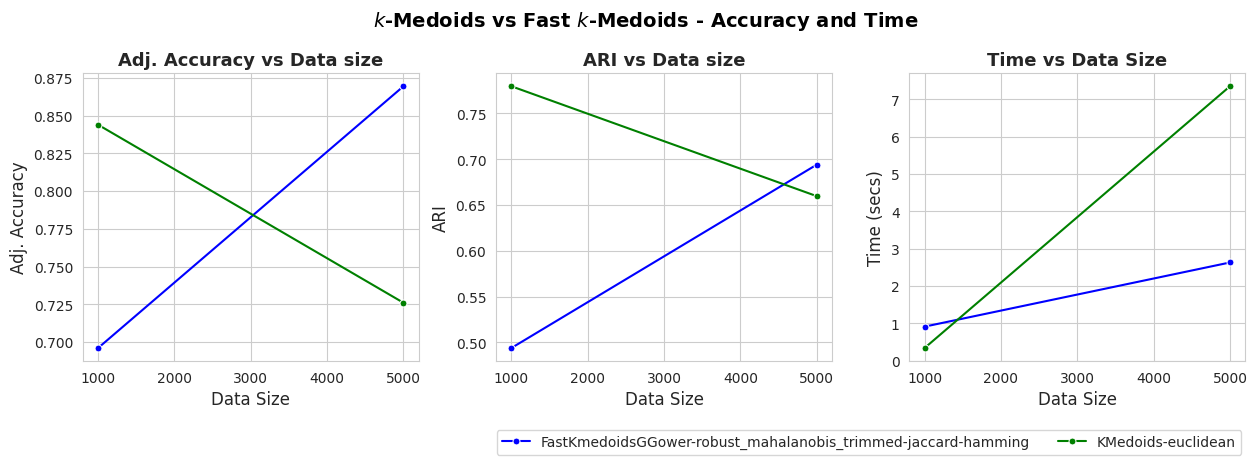

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes = axes.flatten()  

#######################################################################
# Accuracy plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_acc_subset = dfs['adj_accuracy'][dfs['adj_accuracy']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['adj_accuracy'], 
             color='blue', marker='o',  markersize=5, 
             label=model_name, ax=axes[0])

################################

model_name = 'KMedoids-euclidean'
df_acc_subset = dfs['adj_accuracy'][dfs['adj_accuracy']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['adj_accuracy'], 
             color='green', marker='o',  markersize=5, 
             label=model_name, ax=axes[0])


#######################################################################
# ARI plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_acc_subset = dfs['ARI'][dfs['ARI']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['ARI'], 
             color='blue', marker='o',  markersize=5, 
             label=model_name, ax=axes[1])

################################

model_name = 'KMedoids-euclidean'
df_acc_subset = dfs['ARI'][dfs['ARI']['model_name'] == model_name]

sns.lineplot(x=df_acc_subset['n_samples'], 
             y=df_acc_subset['ARI'], 
             color='green', marker='o',  markersize=5, 
             label=model_name, ax=axes[1])


#######################################################################
# Time plot 
#######################################################################

model_name = 'FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming'
df_time_subset = dfs['time'][dfs['time']['model_name'] == model_name]

sns.lineplot(x=df_time_subset['n_samples'], 
             y=df_time_subset['time'], 
             color='blue', marker='o',  markersize=5, 
             label=model_name, ax=axes[2])

################################

model_name = 'KMedoids-euclidean'
df_time_subset = dfs['time'][dfs['time']['model_name'] == model_name]

sns.lineplot(x=df_time_subset['n_samples'], 
             y=df_time_subset['time'], 
             color='green', marker='o',  markersize=5, 
             label=model_name, ax=axes[2])

#######################################################################
# Plot details

axes[0].set_title('Adj. Accuracy vs Data size', size=13, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=12)
#min_acc = min([min(best_accuracy[model].values()) for model in model_names])
#max_acc = max([max(best_accuracy[model].values()) for model in model_names])
#axes[0].set_yticks(np.round(np.linspace(min_acc, max_acc, 6),3))

axes[1].set_title('ARI vs Data size', size=13, weight='bold')
axes[1].set_ylabel('ARI', size=12)


axes[2].set_title('Time vs Data Size', size=13, weight='bold')
axes[2].set_ylabel('Time (secs)', size=12)
#min_time = min([min([x for x in times[model].values() if x != None]) for model in model_names])
#max_time = max([max([x for x in times[model].values() if x != None]) for model in model_names])
#axes[1].set_yticks(np.round(np.linspace(min_time, max_time, 6),3))

for i in range(len(axes)):
    #axes[i].set_xticks(data_sizes + [25000, 35000, 45000])
    axes[i].set_xlabel('Data Size', size=12)
    axes[i].legend().set_visible(False)

handles, labels = axes[1].get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(-0.12, -0.35), ncol=len(labels), fontsize=10)
plt.subplots_adjust(top=0.83)
plt.suptitle('$k$-Medoids vs Fast $k$-Medoids - Accuracy and Time', fontsize=14, y=0.99, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

file_name = 'plots/kmedoids_vs_fast_kmedoids'
#fig.savefig(file_name + '.jpg', format='jpg', dpi=500, bbox_inches="tight", pad_inches=0.2)

plt.show()